# Домашнее задание 5 - соревнование (предсказание звонка в колцентр)

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm


In [27]:
import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)

Python executable: /home/matvey/.pyenv/versions/3.13.7/bin/python3.13
Python version: 3.13.7 (main, Oct 29 2025, 22:13:41) [GCC 13.3.0]


-----
### Загрузка данных



In [28]:
df = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
df_webstat = pd.read_csv('t1_webstat.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [29]:
df.head(1)

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter
0,1269921,1975-12-26 09:30:08,9896348,753,5,8.0,123777004,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20.000,1


In [30]:
df_webstat.head(1)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
0,122243978,1975-12-18 14:52:38.130,2,28,53.0,1773.0,NaN,NaN,NaN,NaN


#### Распределение таргета

In [31]:
df['is_callcenter'].value_counts(normalize=True)

is_callcenter
0    0.645308
1    0.354692
Name: proportion, dtype: float64

In [32]:
!pip install -q git+https://github.com/matveytizhin/my_ml_tools_box.git


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [33]:
from ml_tools import get_df_info
df_info = get_df_info(df)
df_info

,dtype,nunique,example_1,example_2,zero,nan,empty_str,vc_max,trash_score
is_moderated,int64,2,1,0,z:0.049,-1,-1,"(1, 0.951)",0.951240
rating_value,float64,11,5,10,-1,n:0.677,-1,"(5, 0.217)",0.677413
is_callcenter,int64,2,1,0,z:0.645,-1,-1,"(0, 0.645)",0.645308
rating_count,float64,30,6,0,z:0.136,n:0.507,-1,"(1, 0.140)",0.642239
utm_medium,int64,8,5,1,-1,-1,-1,"(1, 0.457)",0.457039
utm_source,float64,289,8,2,-1,n:0.100,-1,"(1, 0.428)",0.428328
description_length,int64,3106,1204,2010,z:0.384,-1,-1,"(0, 0.384)",0.384225
pics_qty,int64,34,2,3,z:0.005,-1,-1,"(1, 0.366)",0.366222
goods_qty,int64,114,6,26,-1,-1,-1,"(1, 0.319)",0.319499
root_id,int64,26,124,201,-1,-1,-1,"(1183, 0.264)",0.263607


In [34]:
df_webstat_info = get_df_info(df_webstat)
df_webstat_info

,dtype,nunique,example_1,example_2,zero,nan,empty_str,vc_max,trash_score
product_in_sale,float64,2,1,<NaN>,-1,n:0.633,-1,"(1, 0.367)",0.632527
price,float64,12299,8436,6624,-1,n:0.633,-1,"(952, 0.002)",0.632527
good_id,float64,233144,45171119,65195750,-1,n:0.633,-1,"(66921494, 0.000)",0.632527
model_id,float64,181760,26706175,17297250,-1,n:0.613,-1,"(18340251, 0.001)",0.613232
page_type,int64,13,2,5,-1,-1,-1,"(1, 0.387)",0.387358
category_id,float64,3549,1773,3973,-1,n:0.294,-1,"(155, 0.038)",0.293526
pageview_duration_sec,float64,2975,53,163,z:0.006,n:0.088,-1,"(9, 0.023)",0.093939
sessionkey_id,int64,328430,122243978,122243992,-1,-1,-1,"(119635649, 0.000)",0.000000
date_time,object,3329535,1975-12-18 14:52:...,1975-12-18 15:02:...,-1,-1,-1,"(1976-01-25 22:35:..., 0.000)",0.000000
pageview_number,int64,632,28,36,-1,-1,-1,"(1, 0.097)",0.000000


### Определение категориальных и числовых признаков

#### **Признаки из train.csv:**

**Категориальные признаки:**
* **`order_id`** - id заказа (__Не используем в качестве признака__)
* **`good_id`** - id товара
* **`utm_medium`** - тип трафика
* **`utm_source`** - источник трафика
* **`sessionkey_id`** - id сессии пользователя
* **`category_id`** - id категории товара
* **`parent_id`** - id родительской категории для категории товара
* **`root_id`** - id "базовой" категории товара
* **`is_moderated`** - нет описания (флаг модерации)
* **`model_create_time`** - нет описания. По всей видимости это дата создания самого товара(модели)
* **`model_id`** - нет описания (наверно id модели товара - кажется можно установить 1-1 соответвие с 

**Числовые признаки:**
* **`price`** - цена товара
* **`rating_value`** - рейтинг товара
* **`rating_count`** - число оценок товара
* **`description_length`** - длина описания товара
* **`goods_qty`** - число товаров в заказе
* __`pics_qty`__ - нет описания, но по названию должно быть кол-вом изображений товара

**Признаки даты/времени:**
* **`create_time`** - время создания заказа

---

#### **Признаки из t1_webstat.csv:**

**Категориальные признаки:**
* **`sessionkey_id`** - id сессии пользователя
* **`page_type`** - тип просмотренной страницы

**Числовые признаки:**
* **`pageview_number`** - порядковый номер страницы среди всех страниц, отсортированных по времени посещения внутри сессии
* **`pageview_duration_sec`** - время просмотра страницы

**Признаки даты/времени:**
* **`date_time`** - timestamp захода на страницу определенного типа

----
#### __Целевая переменная__
* **`is_callcenter`** - был ли совершен звонок в коллцентр по итогам сессии (нужно предсказать)


----
### Baseline model
* Удаляем все строчки в которых есть хотя бы один пропуск
* Используем наиболее простые признаки с точки зрения предобработки и кодирования из __train.csv__

In [35]:
pip install -q category_encoders


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /home/matvey/.pyenv/versions/3.13.7/bin/python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
df_cleaned_nan = df.dropna()
print(f"кол-во удаленных строк {df.shape[0] - df_cleaned_nan.shape[0]} из {df.shape[0]}")

кол-во удаленных строк 74663 из 104595


In [37]:
from sklearn.model_selection import train_test_split

print(df_info['nunique'])

cat_features = [
    'utm_medium', #8
    'utm_source', #289
    'category_id', #1733
    'parent_id', #368
    'root_id', #26
    'is_moderated', #2
    'pics_qty', #34
     'goods_qty', #114
]
num_features = [
    'rating_value', #11
    'rating_count', #30
    'description_length', #3106
]

#OHE
ohe_features = [
    'utm_medium', #8
    'root_id', #26
    'is_moderated', #2
    'pics_qty', #34
]

binary_features = [
    'utm_source', #289
    'category_id', #1733
    'parent_id', #368
     'goods_qty', #114
]

all_features = cat_features + num_features

X_baseline = df_cleaned_nan[all_features]

X_encoded = pd.get_dummies(X_baseline, columns=ohe_features, drop_first=True)
y = df_cleaned_nan['is_callcenter']
binary_encoder = BinaryEncoder(cols=binary_features)
X_encoded = binary_encoder.fit_transform(X_encoded)

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])

print(f'кол-во признаков после кодирования категориальных признаков: {X_train.shape[1]}, a было {len(all_features)}')

is_moderated               2
rating_value              11
is_callcenter              2
rating_count              30
utm_medium                 8
utm_source               289
description_length      3106
pics_qty                  34
goods_qty                114
root_id                   26
model_create_time      31697
good_id                53691
create_time           102998
order_id              104595
model_id               37299
price                   6362
parent_id                368
category_id             1733
sessionkey_id          96803
Name: nunique, dtype: int64
кол-во признаков после кодирования категориальных признаков: 85, a было 11


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(solver='saga', penalty='l1', C=1)
clf.fit(X_train, y_train)
print(f'baseline model roc_auc: {roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])}')

baseline model roc_auc: 0.612534287827557


/home/matvey/.pyenv/versions/3.13.7/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


----
### Заполнение пропусков

In [39]:
#Добавляем флаги пропуска значений, чтобы линейная модель
# могла понимать - это значение изначально было в датасете или я оно 
# было заполнено на этапе препроцессинга

# df['is_pass_rating_value'] = df['rating_value'].isna()
# df['is_pass_rating_count'] = df['rating_count'].isna()

df['is_pass_utm_source'] = df['utm_source'].isna()
df['is_pass_model_create_time'] = df['model_create_time'].isna()

Удалить две трети датасета это конечно смелый шаг. Чтобы не лишать себя дополнительных данных я решил проанализировать причину возникновения пропусков:
#### 1) __rating_value__, __rating_count__. 
Можно увидеть, что рейтинг товара пропущен когда кол-во отзывов либо также пропущено, либо очень маленькое(от 0 до 10 отзывов). Поэтому у меня возникла мысль заполнить пропуски нулями.

In [40]:
print(df.loc[df['rating_value'].isna(), ['rating_value','rating_count']])
print(df.loc[df['rating_value'].isna()]['rating_count'].unique())

        rating_value  rating_count
22               NaN           NaN
109              NaN           NaN
164              NaN           0.0
165              NaN           0.0
185              NaN           0.0
...              ...           ...
104581           NaN           NaN
104582           NaN           NaN
104583           NaN           NaN
104584           NaN           NaN
104585           NaN           NaN

[70854 rows x 2 columns]
[nan  0.  1.  2. 10.  8.  5.  4.  3.]


In [41]:
df[['rating_value','rating_count']] = df[['rating_value','rating_count']].fillna(0)

#### 2) utm_source - источник трафика (10 процентов пропусков).
В большинстве случаев, когда utm_source не заполнен, utm_mediate = 2 (вероятность 0.996). Поэтому я решил заполнить utm_source наиболее частотным значением среди тех объектов, у которых utm_mediate = 2 -> utm_source=3 был наиболее вероятен, причем эта вероятность была целых 0.74, что достаточно много)


In [42]:
print(f"Корреляция utm_source с utm_medium: {df['utm_source'].corr(df['utm_medium'])}")
df[['utm_source', 'utm_medium']] 
# Корреляция utm_source с utm_medium 

Корреляция utm_source с utm_medium: 0.27437828627654065


,utm_source,utm_medium
0,8.0,5
1,2.0,1
2,3.0,2
3,1.0,1
4,56.0,3
...,...,...
104590,1.0,4
104591,2.0,1
104592,NaN,2
104593,2.0,4


In [43]:
# print(df.loc[df['utm_source'].isna(), ['utm_medium']])
print(f"{df.loc[df['utm_source'].isna()]['utm_medium'].value_counts(normalize=True)}")

utm_medium
2    0.996459
7    0.003062
3    0.000383
6    0.000096
Name: proportion, dtype: float64


In [44]:
df.loc[df['utm_medium'] == 2]['utm_source'].value_counts(normalize=True)

utm_source
3.0      0.741747
17.0     0.121675
24.0     0.087153
35.0     0.020939
42.0     0.014714
72.0     0.003962
4.0      0.003584
93.0     0.001886
86.0     0.001509
145.0    0.000755
158.0    0.000566
141.0    0.000566
135.0    0.000377
465.0    0.000189
138.0    0.000189
147.0    0.000189
Name: proportion, dtype: float64

In [45]:
df['utm_source'] = df['utm_source'].fillna(3)

#### 3) model_create_time (1 процент пропуск) - заполняем модой, никаких зависимостей с другими признаками я не увидел


In [46]:
# Заполняем минимальным значением, которое есть в model_create_time 
# в предположениях,что оно пропущено из-за того, чтобы дата создания
# слишком старая
mode_model_create_time = pd.to_datetime(df['model_create_time'])[104594 // 2] #1974-03-27 19:16:20
df.loc[df['model_create_time'].isna(), 'model_create_time'] = mode_model_create_time

date_diff = (pd.to_datetime(df['create_time']) - pd.to_datetime(df['model_create_time'])).dt.total_seconds()
print(f'доля предзаказов, {(date_diff < 0).mean()}')
df[date_diff < 0]['model_create_time'].isna().mean()

доля предзаказов, 0.014264544194273148


np.float64(0.0)

----
### Checkpoint 1 (Провека проделанной работы)

In [47]:
get_df_info(df)['nunique']

is_pass_model_create_time         2
is_moderated                      2
is_pass_utm_source                2
rating_value                     11
is_callcenter                     2
rating_count                     29
utm_medium                        8
utm_source                      288
description_length             3106
pics_qty                         34
goods_qty                       114
root_id                          26
order_id                     104595
price                          6362
good_id                       53691
create_time                  102998
parent_id                       368
model_id                      37299
sessionkey_id                 96803
category_id                    1733
model_create_time             31697
Name: nunique, dtype: int64

In [48]:
from sklearn.model_selection import train_test_split

# print(df_info['nunique'])

cat_features = [
    'utm_medium', #8
    'utm_source', #289
    'category_id', #1733
    'parent_id', #368
    'root_id', #26
    'is_moderated', #2
    'pics_qty', #34
    'goods_qty', #114
    # 'is_pass_model_create_time', #2
    # 'is_moderated',
    # 'is_pass_utm_source',
]
num_features = [
    'rating_value', #11
    'rating_count', #30
    'description_length', #3106
]

#OHE
ohe_features = [
    'utm_medium', #8
    'root_id', #26
    'pics_qty', #34
]

binary_encoding_features = [
    'utm_source', #289
    'category_id', #1733
    'parent_id', #368
     'goods_qty', #114
]

all_features = cat_features + num_features

X_baseline = df[all_features]

X_encoded = pd.get_dummies(X_baseline, columns=ohe_features, drop_first=True)
y = df['is_callcenter']
binary_encoder = BinaryEncoder(cols=binary_features)
X_encoded = binary_encoder.fit_transform(X_encoded)

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])

print(f'кол-во признаков после кодирования категориальных признаков: {X_train.shape[1]}, a было {len(all_features)}')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(solver='saga', penalty='l1', C=1)
clf.fit(X_train, y_train)
print(f'baseline model roc_auc: {roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])}')

кол-во признаков после кодирования категориальных признаков: 105, a было 11
baseline model roc_auc: 0.6178691219740999


/home/matvey/.pyenv/versions/3.13.7/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [49]:
clf = LogisticRegression(
        solver='saga',
        C=1,
        penalty='l1',
        max_iter=500,
        class_weight='balanced',
    )
clf.fit(X_train, y_train)
print(f'baseline model roc_auc: {roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])}')

baseline model roc_auc: 0.6179847755284977


/home/matvey/.pyenv/versions/3.13.7/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


----------
## Анализ признаков

``` python
В baseline модели мы использовали эти признаки
['utm_medium',
 'utm_source',
 'category_id',
 'parent_id',
 'root_id',
 'is_moderated',
 'pics_qty',
 'goods_qty',
 'rating_value',
 'rating_count',
 'description_length']
забыв при этом про остальные. Сейчас я проанализирую оставшиеся признаки из train.csv, чтобы добавить их в обучение

Оставшиеся признаки:
model_create_time      31697
model_id               37299
create_time           102998
good_id                53691
sessionkey_id          96803
```

#### 1) Работа с временными признаками __model_create_time__ и __create_time__ 
Что я делаю с этими признаками:

* Признак __create_time__  разбиваю на компоненты: год, месяц, день, час. А также добавляю признаки - день недели и время суток(утро, день, вечер, ночь)
* Признак __model_create_time__ - сам по себе малоинформативен. Вместо него я использую разницу между датой создания модели товара и датой создания заказа.
* Есть случаи, когда покупатель заказывает раньше выхода модели, т.е делает предзаказ, поэтому я добавил признак __is_pre_order__, который  будет помогать это отслеживать

In [50]:
df['year_order'] = pd.to_datetime(df['create_time']).dt.year #OHE
df['month_order'] = pd.to_datetime(df['create_time']).dt.month #OHE
df['day_order'] = pd.to_datetime(df['create_time']).dt.day # можно попробовать оставить как есть (то есть думать что это числовой признак)
df['hour_order'] = pd.to_datetime(df['create_time']).dt.hour #можно использовать циклическое кодирование (пока тоже OHE для baseline)
df['weekday_order'] = pd.to_datetime(df['create_time']).dt.weekday

df['time_of_day'] = pd.cut(
    df['hour_order'],
    bins=[-1, 6, 12, 18, 24],
    labels=['ночь', 'утро', 'день', 'вечер'],
    right=False
)

In [51]:
df.loc[df['model_create_time'].isna()]

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,...,model_create_time,is_callcenter,is_pass_utm_source,is_pass_model_create_time,year_order,month_order,day_order,hour_order,weekday_order,time_of_day


In [52]:
df['date_diff'] = (pd.to_datetime(df['create_time']) - pd.to_datetime(df['model_create_time'])).dt.total_seconds()
print(f"доля предзаказов, {(df['date_diff'] < 0).mean()}")
df['is_pre_order'] = df['date_diff'] < 0

доля предзаказов, 0.014264544194273148


----
### Checkpoint 2 (Провека проделанной работы)

In [53]:
get_df_info(df)['nunique'].loc[['is_pass_utm_source', 'is_pass_model_create_time', 'year_order', 'month_order', 'day_order', 'hour_order', 'weekday_order', 'time_of_day', 'date_diff', 'is_pre_order']]

is_pass_utm_source                2
is_pass_model_create_time         2
year_order                        2
month_order                       3
day_order                        31
hour_order                       12
weekday_order                     7
time_of_day                       3
date_diff                    104542
is_pre_order                      2
Name: nunique, dtype: int64

In [54]:
       'year_order', 'month_order', 'day_order', 'hour_order', 'weekday_order',
       'time_of_day', 'date_diff', 'is_pre_order'

('time_of_day', 'date_diff', 'is_pre_order')

In [55]:
from category_encoders import TargetEncoder


In [56]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# print(df_info['nunique'])


cat_features = [
    'utm_medium', #8
    'utm_source', #289
    'category_id', #1733
    'parent_id', #368
    'root_id', #26
    'model_id', #37299
    'is_moderated', #2
    'pics_qty', #34
    'goods_qty', #114
    'is_pass_model_create_time', #2
    'is_pass_utm_source',
    'year_order',
    'month_order', 
    # 'day_order', 
    'hour_order', 
    'weekday_order',
    'time_of_day', 
    'is_pre_order',
    
]
num_features = [
    'rating_value', #11
    'rating_count', #30
    'description_length', #3106
    # 'date_diff', #104542
    
]

#OHE
ohe_features = [
    'utm_medium', #8
    'pics_qty', #34
    'hour_order', 
    # 'day_order', 
    'month_order', 
    'year_order',
    'weekday_order',
    'time_of_day', 
    'root_id', #26
    
]

binary_encoding_features = [
    'utm_source', #289
     'goods_qty', #114
    'category_id', #1733
    'parent_id', #368
    'model_id' #37299
]

target_encoding_features = [
    
]

all_features = cat_features + num_features

X_baseline = df[all_features]

X_encoded = pd.get_dummies(X_baseline, columns=ohe_features, drop_first=True)
y = df['is_callcenter']
binary_encoder = BinaryEncoder(cols=binary_encoding_features)
X_encoded = binary_encoder.fit_transform(X_encoded)

X_encoded['day_sin'] = np.sin(2 * np.pi * df['day_order'] / 31)
X_encoded['day_cos'] = np.cos(2 * np.pi * df['day_order'] / 31)

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

encoder = TargetEncoder(cols=target_encoding_features)
X_train[target_encoding_features] = encoder.fit_transform(X_train[target_encoding_features], y=y_train)
X_val[target_encoding_features] = encoder.transform(X_val[target_encoding_features])

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])

print(f'кол-во признаков после кодирования категориальных признаков: {X_train.shape[1]}, a было {len(all_features)}')


clf = LogisticRegression(solver='saga', penalty='l1', C=0.1, class_weight='balanced', max_iter=2000)
clf.fit(X_train, y_train)

print(f'X_train roc_auc: {roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])}')
print(f'X_val roc_auc: {roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])}')


кол-во признаков после кодирования категориальных признаков: 149, a было 20
X_train roc_auc: 0.6402782610837677
X_val roc_auc: 0.6389632609501376


In [57]:
y_train.shape

(73216,)

----
### Используем признаки из __webstat.csv__

In [58]:
df_webstat_agg = df_webstat.groupby(by='sessionkey_id', as_index=False).first()

In [59]:
get_df_info(df_webstat_agg)

,dtype,nunique,example_1,example_2,zero,nan,empty_str,vc_max,trash_score
product_in_sale,float64,2,1,<NaN>,-1,n:0.197,-1,"(1, 0.803)",0.803139
pageview_number,int64,137,5,1,-1,-1,-1,"(1, 0.500)",0.500076
page_type,int64,13,2,7,-1,-1,-1,"(1, 0.467)",0.467278
pageview_duration_sec,float64,1914,11,122,z:0.008,n:0.232,-1,"(10, 0.016)",0.240252
price,float64,8729,2986,4490,-1,n:0.197,-1,"(952, 0.004)",0.196861
good_id,float64,94987,22312252,55614318,-1,n:0.197,-1,"(66921494, 0.002)",0.196861
model_id,float64,76666,8748965,1513237,-1,n:0.157,-1,"(18340251, 0.004)",0.156569
category_id,float64,2742,723,206,-1,n:0.062,-1,"(155, 0.080)",0.062376
date_time,object,328362,1975-10-17 13:44:...,1975-10-17 15:25:...,-1,-1,-1,"(1975-12-03 09:42:..., 0.000)",0.000000
sessionkey_id,int64,328430,109996122,110019268,-1,-1,-1,"(109996122, 0.000)",0.000000


In [103]:
df_merged = pd.merge(df, df_webstat_agg[['sessionkey_id', 'page_type', 'pageview_duration_sec','pageview_number', 'product_in_sale', 'date_time']], on='sessionkey_id', how='left')

In [61]:
df_merged['product_in_sale'] = df_merged['product_in_sale'].fillna(0)

In [62]:
df_merged.loc[df_merged['page_type'].isna()]

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,...,day_order,hour_order,weekday_order,time_of_day,date_diff,is_pre_order,page_type,pageview_duration_sec,pageview_number,product_in_sale
154,1287030,1976-01-05 13:22:18,67142321,1561,3,12.0,125592233,155,154,153,...,5,13,0,день,148572922.0,False,NaN,NaN,NaN,0.0
864,1169533,1975-11-06 11:37:25,63404371,1338,5,8.0,113969090,1200,5674,1183,...,6,11,3,утро,133131133.0,False,NaN,NaN,NaN,0.0
911,1208051,1975-11-25 13:39:29,5364697,2357,3,6.0,117433285,170,169,153,...,25,13,1,день,143061496.0,False,NaN,NaN,NaN,0.0
1455,1327152,1976-01-26 09:00:57,9896348,889,2,3.0,130361576,139,133,124,...,26,9,0,утро,151058737.0,False,NaN,NaN,NaN,0.0
1495,1251675,1975-12-16 15:18:04,68140757,844,2,3.0,116497085,155,154,153,...,16,15,1,день,146853447.0,False,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104448,1233896,1975-12-08 10:31:14,65304908,10806,5,47.0,120130598,3988,202,201,...,8,10,0,утро,-5605334.0,True,NaN,NaN,NaN,0.0
104467,1229646,1975-12-05 10:45:36,36747613,656,3,21.0,119598230,1214,1213,1183,...,5,10,4,утро,-4608036.0,True,NaN,NaN,NaN,0.0
104531,1189773,1975-11-17 11:03:49,20276482,2545,2,3.0,115843722,2360,1634,1634,...,17,11,0,утро,-6511182.0,True,NaN,NaN,NaN,0.0
104554,1276214,1975-12-30 11:42:45,57998993,1271,6,4.0,124503145,196,184,3368,...,30,11,1,утро,-4127521.0,True,NaN,NaN,NaN,0.0


In [113]:
df_merged_cleaned_nan = df_merged.dropna()


In [64]:
# Импорты
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder, TargetEncoder

def create_datetime_features(df):
    df = df.copy()
    df['day_sin'] = np.sin(2 * np.pi * df['day_order'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_order'] / 31)
    return df

def encode_categorical_features(
    df, 
    ohe_features=None,
    binary_features=None,
    target_features=None,
    y=None,
    target_encoder=None
):
    df = df.copy()
    if ohe_features:
        df = pd.get_dummies(df, columns=ohe_features, drop_first=True)
    if binary_features:
        encoder = BinaryEncoder(cols=binary_features, return_df=True)
        df = encoder.fit_transform(df)
    if target_features and y is not None:
        if target_encoder is None:
            target_encoder = TargetEncoder(cols=target_features, return_df=True)
            df = target_encoder.fit_transform(df, y)
        else:
            df = target_encoder.transform(df)
    return df, target_encoder

def split_and_scale(X, y, num_features, test_size=0.3, random_state=42):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler()
    X_train.loc[:, num_features] = scaler.fit_transform(X_train[num_features])
    X_val.loc[:, num_features] = scaler.transform(X_val[num_features])
    return X_train, X_val, y_train, y_val, scaler

def prepare_modeling_data(
    df,
    cat_features,
    num_features,
    ohe_features=None,
    binary_features=None,
    target_features=None,
    target_col='is_callcenter',
    test_size=0.3,
    random_state=42
):
    all_features = cat_features + num_features
    df_prep = df[all_features + [target_col]].copy()
    df_prep = create_datetime_features(df_prep)
    
    X = df_prep[all_features + ['day_sin', 'day_cos']]
    y = df_prep[target_col]
    
    X_encoded, _ = encode_categorical_features(
        X,
        ohe_features=ohe_features,
        binary_features=binary_features
    )
    
    # Обновляем список числовых признаков
    num_features_updated = num_features + ['day_sin', 'day_cos']
    
    X_train, X_val, y_train, y_val, scaler = split_and_scale(
        X_encoded, y, num_features_updated, test_size, random_state
    )
    
    if target_features:
        te = TargetEncoder(cols=target_features, return_df=True)
        X_train = te.fit_transform(X_train, y_train)
        X_val = te.transform(X_val)
    
    return X_train, X_val, y_train, y_val

In [86]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# print(df_info['nunique'])


cat_features = [
    'utm_medium', #8
    'utm_source', #289
    'category_id', #1733
    'parent_id', #368
    'root_id', #26
    'model_id', #37299
    'is_moderated', #2
    'pics_qty', #34
    'goods_qty', #114
    'is_pass_model_create_time', #2
    'is_pass_utm_source',
    'year_order',
    'month_order', 
    # 'day_order', 
    'hour_order', 
    'weekday_order',
    'time_of_day', 
    'is_pre_order',
    'page_type',
    'pageview_number',
    'product_in_sale',
    
    
]
num_features = [
    'rating_value', #11
    'rating_count', #30
    'description_length', #3106
    'date_diff', #104542
    'pageview_duration_sec',  
]

#OHE
ohe_features = [
    # 'utm_medium', #8
    'pics_qty', #34
    'hour_order', 
    # 'day_order', 
    'month_order', 
    'year_order',
    'weekday_order',
    'time_of_day', 
    'root_id', #26
    'page_type',
]

binary_encoding_features = [
    'utm_source', #289
     'goods_qty', #114
    'category_id', #1733
    'parent_id', #368
    'model_id', #37299   
    'pageview_number',
    
]
target_encoding_features = [
    
]
def build_train_val_split_with_encoding(df, cat_features, num_features, ohe_features, binary_encoding_features, target_encoding_features):
    all_features = cat_features + num_features
    X_baseline = df[all_features]

    X_encoded = pd.get_dummies(X_baseline, columns=ohe_features, drop_first=True)
    y = df['is_callcenter']
    
    binary_encoder = BinaryEncoder(cols=binary_encoding_features)
    X_encoded = binary_encoder.fit_transform(X_encoded)
    
    X_encoded['day_sin'] = np.sin(2 * np.pi * df['day_order'] / 31)
    X_encoded['day_cos'] = np.cos(2 * np.pi * df['day_order'] / 31)
    
    X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
    
    encoder = TargetEncoder(cols=target_encoding_features)
    X_train[target_encoding_features] = encoder.fit_transform(X_train[target_encoding_features], y=y_train)
    X_val[target_encoding_features] = encoder.transform(X_val[target_encoding_features])
    
    scaler = StandardScaler()
    X_train[num_features] = scaler.fit_transform(X_train[num_features])
    X_val[num_features] = scaler.transform(X_val[num_features])
    
    print(f'кол-во признаков после кодирования категориальных признаков: {X_train.shape[1]}, a было {len(all_features)}')

    return X_train, y_train, X_val, y_val
    
X_train, y_train, X_val, y_val = build_train_val_split_with_encoding(df_merged_cleaned_nan, cat_features, num_features, ohe_features, binary_encoding_features, target_encoding_features)

clf_master = LogisticRegression(solver='saga', penalty='l1', C=0.1, class_weight='balanced', max_iter=1000)
clf_master.fit(X_train, y_train)

print(f'X_train roc_auc: {roc_auc_score(y_train, clf_master.predict_proba(X_train)[:, 1])}')
print(f'X_val roc_auc: {roc_auc_score(y_val, clf_master.predict_proba(X_val)[:, 1])}')

кол-во признаков после кодирования категориальных признаков: 164, a было 25
X_train roc_auc: 0.691287999058197
X_val roc_auc: 0.691552353607098


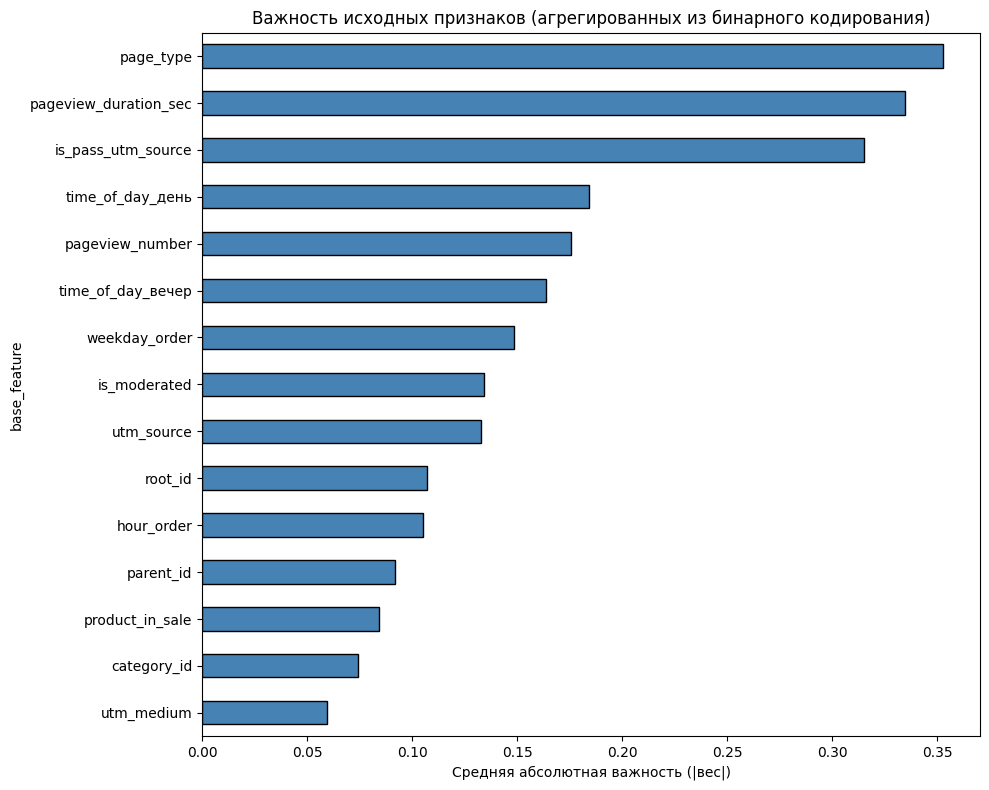

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

#GPT_FUNCTION
def importance_features(coef, feature_names):
    df_weights = pd.DataFrame({
        'feature_encoded': feature_names,
        'weight': coef
    })
    
    df_weights['base_feature'] = df_weights['feature_encoded'].apply(
        lambda x: re.sub(r'_\d+(?:\.\d+)?$', '', x)
    )
    
    feature_importance = (
        df_weights
        .groupby('base_feature')['weight']
        .apply(lambda x: np.abs(x).mean())
        .sort_values(ascending=False)
    )
    
    top_base_features = feature_importance.head(15)
    
    plt.figure(figsize=(10, 8))
    top_base_features.plot(kind='barh', color='steelblue', edgecolor='black')
    plt.xlabel('Средняя абсолютная важность (|вес|)')
    plt.title('Важность исходных признаков (агрегированных из бинарного кодирования)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
coef_master = clf_master.coef_[0]
feature_names = X_train.columns
importance_features(coef_master, feature_names)

#### Сделаем для каждой категории из utm_medium свою модель


In [67]:
df_merged['utm_medium'].value_counts()

utm_medium
1    47804
2    15714
5    14025
4    12724
6     8627
7     3178
3     2270
8      253
Name: count, dtype: int64

In [102]:
df_webstat

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
0,122243978,1975-12-18 14:52:38.130,2,28,53.0,1773.0,NaN,NaN,NaN,NaN
1,122243978,1975-12-18 15:02:32.403,5,36,163.0,NaN,NaN,NaN,NaN,NaN
2,122243978,1975-12-18 15:08:11.147,5,40,156.0,NaN,NaN,NaN,NaN,NaN
3,122243992,1975-12-18 14:23:33.177,1,4,565.0,3973.0,26706175.0,45171119.0,8436.0,1.0
4,122243992,1975-12-18 14:32:58.763,1,5,73.0,3973.0,17297250.0,65195750.0,6624.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3334238,119215415,1975-12-03 14:45:42.320,1,2,NaN,141.0,856955.0,26681969.0,3467.0,1.0
3334239,119215471,1975-12-03 14:45:30.520,6,5,21.0,NaN,NaN,NaN,NaN,NaN
3334240,119215471,1975-12-03 14:50:11.470,6,8,16.0,NaN,NaN,NaN,NaN,NaN
3334241,119215471,1975-12-03 14:50:56.133,6,10,7.0,NaN,NaN,NaN,NaN,NaN


In [111]:
get_df_info(df_merged)

,dtype,nunique,example_1,example_2,zero,nan,empty_str,vc_max,trash_score
is_pass_model_create_time,bool,2,False,True,-1,-1,-1,"(False, 0.990)",0.989837
is_pre_order,bool,2,False,True,-1,-1,-1,"(False, 0.986)",0.985735
is_moderated,int64,2,1,0,z:0.049,-1,-1,"(1, 0.951)",0.951240
product_in_sale,float64,2,1,<NaN>,-1,n:0.081,-1,"(1, 0.919)",0.918581
is_pass_utm_source,bool,2,False,True,-1,-1,-1,"(False, 0.900)",0.900091
rating_value,float64,11,5,10,z:0.677,-1,-1,"(0, 0.677)",0.677413
year_order,int32,2,1975,1976,-1,-1,-1,"(1975, 0.660)",0.659773
year,float64,3,1975,1976,-1,n:0.006,-1,"(1975, 0.658)",0.657995
is_callcenter,int64,2,1,0,z:0.645,-1,-1,"(0, 0.645)",0.645308
rating_count,float64,29,6,0,z:0.642,-1,-1,"(0, 0.642)",0.642239


In [110]:
df_merged['day'] = pd.to_datetime(df_merged['date_time']).dt.day
df_merged['year'] = pd.to_datetime(df_merged['date_time']).dt.year
df_merged['month'] = pd.to_datetime(df_merged['date_time']).dt.month
df_merged['week'] = pd.to_datetime(df_merged['date_time']).dt.weekday


df_merged['hour'] = pd.to_datetime(df_merged['date_time']).dt.hour 
df_merged['day_part'] = pd.cut(
    df_merged['hour'],
    bins=[-1, 6, 12, 18, 24],
    labels=['ночь', 'утро', 'день', 'вечер'],
    right=False
)

In [121]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# print(df_info['nunique'])

# cat_features = [
#     'utm_medium', #8
#     # 'utm_source', #289
#     'category_id', #1733
#     # 'parent_id', #368
#     'root_id', #26
#     'model_id', #37299
#     # 'is_moderated', #2
#     # 'pics_qty', #34
#     # 'goods_qty', #114
#     # 'is_pass_model_create_time', #2
#     # 'is_pass_utm_source',
#     # 'year_order',
#     # 'month_order', 
#     # 'day_order', 
#     # 'hour_order', 
#     # 'weekday_order',
#     # 'time_of_day', 
#     # 'is_pre_order',
#     'page_type',
#     # 'pageview_number',
#     'product_in_sale',
#     # 'day',
#     # 'year',
#     # 'month',
#     'week',
#     # 'hour',
#     # 'day_part'
    
    
# ]
num_features = [
    # 'rating_value', #11
    # 'rating_count', #30
    # 'description_length', #3106
    # 'date_diff', #104542
    # 'pageview_duration_sec',  
    'price'
]

#OHE
ohe_features = [
    'utm_medium', #8
    # 'pics_qty', #34
    'hour_order', 
    # 'day_order', 
    # 'month_order', 
    # 'year_order',
    # 'weekday_order',
    # 'time_of_day', 
    'root_id', #26
    'page_type',
    # 'day',
    # 'year',
    # 'month',
    # 'week',
    # 'hour',
    # 'day_part'
]

binary_encoding_features = [
    # 'utm_source', #289
     # 'goods_qty', #114
    'category_id', #1733
    # 'parent_id', #368
    'model_id', #37299   
    'pageview_number',
    
]
target_encoding_features = [
    
]


def build_train_val_split_with_encoding(df, cat_features, num_features, ohe_features, binary_encoding_features, target_encoding_features):
    all_features = ohe_features + binary_encoding_features + target_encoding_features + num_features
    X_baseline = df[all_features]

    X_encoded = pd.get_dummies(X_baseline, columns=ohe_features, drop_first=True)
    y = df['is_callcenter']
    
    binary_encoder = BinaryEncoder(cols=binary_encoding_features)
    X_encoded = binary_encoder.fit_transform(X_encoded)
    
    X_encoded['day_sin'] = np.sin(2 * np.pi * df['day_order'] / 31)
    X_encoded['day_cos'] = np.cos(2 * np.pi * df['day_order'] / 31)
    
    X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
    
    encoder = TargetEncoder(cols=target_encoding_features)
    X_train[target_encoding_features] = encoder.fit_transform(X_train[target_encoding_features], y=y_train)
    X_val[target_encoding_features] = encoder.transform(X_val[target_encoding_features])
    
    scaler = StandardScaler()
    X_train[num_features] = scaler.fit_transform(X_train[num_features])
    X_val[num_features] = scaler.transform(X_val[num_features])
    
    print(f'кол-во признаков после кодирования категориальных признаков: {X_train.shape[1]}, a было {len(all_features)}')

    return X_train, y_train, X_val, y_val
    
def split_df_by_feature_and_equation(df, feature_name, master_clf, partition=None):

    models = {}
    
    #Сейчас функция предназначена только для cat_features
    X_train, y_train, X_val, y_val = build_train_val_split_with_encoding(df_merged_cleaned_nan, cat_features, num_features, ohe_features, binary_encoding_features, target_encoding_features)
    df_train = pd.concat([X_train, y_train], axis=1)
    df_val = pd.concat([X_val, y_val], axis=1)
    
    
    for  i, group in enumerate(partition):
        df_group_train = df_train.loc[df[feature_name].isin(group)] #получили датасет для подгруппы
        X_group_train = df_group_train.drop(columns=['is_callcenter'])
        y_group_train = df_group_train['is_callcenter']

        df_group_val = df_val.loc[df[feature_name].isin(group)] #получили датасет для подгруппы
        X_group_val = df_group_val.drop(columns=['is_callcenter'])
        y_group_val = df_group_val['is_callcenter']

        clf = LogisticRegression(
            solver='lbfgs', 
            penalty='l2', 
            C=0.1, 
            class_weight='balanced', 
            max_iter=1000,
            random_state=42
        )  

        clf.fit(X_group_train, y_group_train)
        print('-----------------------------------------------------------------')
        print(f'{i}) X_train roc_auc clf_group: {roc_auc_score(y_group_train, clf.predict_proba(X_group_train)[:, 1])}')
        print(f'{i}) X_val roc_auc clf_group: {roc_auc_score(y_group_val, clf.predict_proba(X_group_val)[:, 1])}  <---')
        print('-                  -               -             -                -            -    ')
        print(f'{i}) X_train roc_auc clf_master: {roc_auc_score(y_group_train, clf_master.predict_proba(X_group_train)[:, 1])}')
        print(f'{i}) X_val roc_auc clf_master: {roc_auc_score(y_group_val, clf_master.predict_proba(X_group_val)[:, 1])} <---')
        print('-----------------------------------------------------------------')
        models[i] = clf
        

    return models


# feature_name = 'page_type'
# partition = [[i] for i in df_merged[feature_name].unique()]
# split_df_by_feature_and_equation(df=df_merged, feature_name=feature_name, master_clf=clf_master, partition=partition)
        
X_train, y_train, X_val, y_val = build_train_val_split_with_encoding(df_merged_cleaned_nan, cat_features, num_features, ohe_features, binary_encoding_features, target_encoding_features)
clf = LogisticRegression(solver='saga', penalty='l1', C=0.1, class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)

    

кол-во признаков после кодирования категориальных признаков: 91, a было 8


,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


In [122]:
print(f'X_train roc_auc: {roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])}')
print(f'X_val roc_auc: {roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])}')
# 

X_train roc_auc: 0.684319193777636
X_val roc_auc: 0.6745182650191844


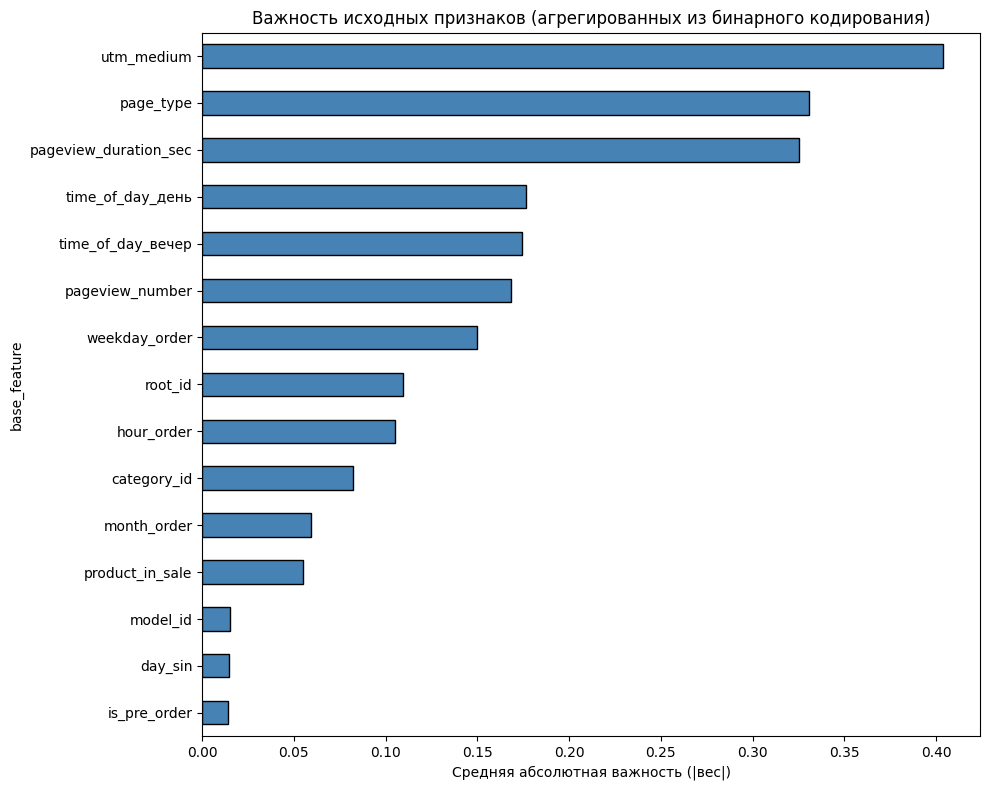

In [95]:
coef = clf.coef_[0]
feature_names = X_train.columns

importance_features(coef, feature_names)